<a href="https://colab.research.google.com/github/JKEVIN2010/Deep-Learning-and-Early-Dementia-Detection/blob/main/Deep_Learning_for_Dementia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt

# For model building
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Lambda, Embedding, Flatten, Conv2D, MaxPooling2D, Dropout, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# For image processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# For evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Download NLTK data files
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load the dataset
df = pd.read_csv('cookie.csv')  # Ensure 'cookie.csv' is in your working directory

# Display the first few rows
print(df.head())


   Unnamed: 0                                               utts  labels
0         142  well â€¡ the stool is falling over . the boy i...       0
1         355  these two little kids are getting cookies out ...       1
2          79  mhm . there is a boy and a girl and the boy is...       0
3         366  the girls trying  ... did I get that ? and gir...       1
4         215  there is a girl waiting to get a cookie from I...       0


In [ ]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Remove unwanted special characters if necessary
    text = re.sub(r'[^a-zA-Z0-9\s.,?!]', '', text)
    # Convert text to lowercase (optional)
    text = text.lower()
    # Tokenize text into characters
    characters = list(text)
    return characters

# Apply preprocessing to the 'utts' column
df['characters'] = df['utts'].apply(preprocess_text)

# Display the processed characters
print(df[['utts', 'characters']].head())


                                                utts  \
0  well â€¡ the stool is falling over . the boy i...   
1  these two little kids are getting cookies out ...   
2  mhm . there is a boy and a girl and the boy is...   
3  the girls trying  ... did I get that ? and gir...   
4  there is a girl waiting to get a cookie from I...   

                                          characters  
0  [w, e, l, l,  ,  , t, h, e,  , s, t, o, o, l, ...  
1  [t, h, e, s, e,  , t, w, o,  , l, i, t, t, l, ...  
2  [m, h, m,  , .,  , t, h, e, r, e,  , i, s,  , ...  
3  [t, h, e,  , g, i, r, l, s,  , t, r, y, i, n, ...  
4  [t, h, e, r, e,  , i, s,  , a,  , g, i, r, l, ...  


In [ ]:
# Create a set of all unique characters in the dataset
all_characters = set()
for chars in df['characters']:
    all_characters.update(chars)
char_list = sorted(list(all_characters))
print(f"Unique characters: {char_list}")

# Create a mapping from character to index
char_to_index = {char: idx for idx, char in enumerate(char_list)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

# Define the vocabulary size
vocab_size = len(char_list)
print(f"Vocabulary size (number of unique characters): {vocab_size}")

# Function to convert characters to one-hot embeddings
def characters_to_onehot(characters):
    indices = [char_to_index[char] for char in characters]
    onehot_embeddings = np.eye(vocab_size)[indices]
    return onehot_embeddings

# Apply the function to create a new column with embeddings
df['embeddings'] = df['characters'].apply(characters_to_onehot)

# Display the embeddings
print(df[['characters', 'embeddings']].head())


Unique characters: [' ', '!', ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size (number of unique characters): 31
                                          characters  \
0  [w, e, l, l,  ,  , t, h, e,  , s, t, o, o, l, ...   
1  [t, h, e, s, e,  , t, w, o,  , l, i, t, t, l, ...   
2  [m, h, m,  , .,  , t, h, e, r, e,  , i, s,  , ...   
3  [t, h, e,  , g, i, r, l, s,  , t, r, y, i, n, ...   
4  [t, h, e, r, e,  , i, s,  , a,  , g, i, r, l, ...   

                                          embeddings  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  


In [ ]:
# Convert characters to indices
def characters_to_indices(characters):
    indices = [char_to_index[char] for char in characters]
    return indices

# Apply the function to create a new column with indices
df['char_indices'] = df['characters'].apply(characters_to_indices)

# Determine the maximum sequence length
sequence_lengths = df['char_indices'].apply(len)
max_sequence_length = int(sequence_lengths.max())
print(f"Maximum sequence length set to: {max_sequence_length}")

# Pad or truncate the sequences
df['padded_indices'] = pad_sequences(
    df['char_indices'],
    maxlen=max_sequence_length,
    padding='post',
    truncating='post'
).tolist()

# Display the padded indices
print(df[['char_indices', 'padded_indices']].head())


Maximum sequence length set to: 2544
                                        char_indices  \
0  [27, 9, 16, 16, 0, 0, 24, 12, 9, 0, 23, 24, 19...   
1  [24, 12, 9, 23, 9, 0, 24, 27, 19, 0, 16, 13, 2...   
2  [17, 12, 17, 0, 3, 0, 24, 12, 9, 22, 9, 0, 13,...   
3  [24, 12, 9, 0, 11, 13, 22, 16, 23, 0, 24, 22, ...   
4  [24, 12, 9, 22, 9, 0, 13, 23, 0, 5, 0, 11, 13,...   

                                      padded_indices  
0  [27, 9, 16, 16, 0, 0, 24, 12, 9, 0, 23, 24, 19...  
1  [24, 12, 9, 23, 9, 0, 24, 27, 19, 0, 16, 13, 2...  
2  [17, 12, 17, 0, 3, 0, 24, 12, 9, 22, 9, 0, 13,...  
3  [24, 12, 9, 0, 11, 13, 22, 16, 23, 0, 24, 22, ...  
4  [24, 12, 9, 22, 9, 0, 13, 23, 0, 5, 0, 11, 13,...  


In [ ]:
# Function to compute the recurrence matrix from embeddings
def calculate_recurrence_matrix(sequence, epsilon=None):
    sequence = np.array(sequence)
    N = sequence.shape[0]
    # Compute the distance matrix
    distance_matrix = np.linalg.norm(sequence[:, None, :] - sequence[None, :, :], axis=2)
    if epsilon is None:
        epsilon = 0.1 * np.std(distance_matrix)
        if epsilon == 0:
            epsilon = 0.001
    recurrence_matrix = np.zeros((N, N))
    recurrence_matrix[distance_matrix <= epsilon] = 1
    return recurrence_matrix


In [ ]:
# Initialize an embedding layer
embedding_dim = 32  # You can choose the dimension
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)

# Build a model to get embeddings
input_seq = Input(shape=(max_sequence_length,))
embedded_seq = embedding_layer(input_seq)
embedding_model = Model(inputs=input_seq, outputs=embedded_seq)

# Get the embeddings for all sequences
padded_indices_array = np.array(df['padded_indices'].tolist())
embeddings = embedding_model.predict(padded_indices_array)

# embeddings shape: (num_samples, median_sequence_length, embedding_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
# Directory to save recurrence plots
recurrence_plots_dir = 'recurrence_plots_characters'
if not os.path.exists(recurrence_plots_dir):
    os.makedirs(recurrence_plots_dir)

# Function to save recurrence plots
def save_recurrence_plot(recurrence_matrix, file_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()

# Generate and save recurrence plots
print("\nGenerating and saving recurrence plots...")
for i, (index, row) in enumerate(df.iterrows()):
    label = 'Dementia' if row['labels'] == 0 else 'Healthy'
    sample_indices = row['padded_indices']
    # Get the embeddings for the sample
    if 'embeddings' in df.columns:
        # If using one-hot embeddings
        sample_embeddings = row['embeddings']
    else:
        # If using learnable embeddings
        sample_embeddings = embeddings[i]
    # Compute the recurrence matrix
    recurrence_matrix = calculate_recurrence_matrix(sample_embeddings)
    # Define the filename
    file_name = os.path.join(recurrence_plots_dir, f'sample_{i}_{label}.png')
    # Save the recurrence plot
    save_recurrence_plot(recurrence_matrix, file_name)
print("Recurrence plots generated and saved.")



Generating and saving recurrence plots...
Recurrence plots generated and saved.


In [ ]:
# Function to load images and labels
def load_images(image_folder, target_size=(128, 128)):
    images = []
    labels = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            img_path = os.path.join(image_folder, file_name)
            img = load_img(img_path, target_size=target_size, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            label = 0 if 'Dementia' in file_name else 1
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(recurrence_plots_dir)

# Verify the shapes
print(f'\nImages shape: {images.shape}')
print(f'Labels shape: {labels.shape}')



Images shape: (552, 128, 128, 1)
Labels shape: (552,)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Verify the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (441, 128, 128, 1)
X_val shape: (111, 128, 128, 1)
y_train shape: (441,)
y_val shape: (111,)


In [ ]:
# Option 1: Deep Metric Learning With Siamese Network
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    min_samples = min([len(class_indices[i]) for i in range(num_classes)]) - 1

    for idx in range(min_samples):
        for class_idx in range(num_classes):
            # Positive pair (same class)
            anchor_idx = class_indices[class_idx][idx]
            positive_idx = class_indices[class_idx][idx + 1]
            pairs.append([images[anchor_idx], images[positive_idx]])
            pair_labels.append(1)

            # Negative pair (different class)
            negative_class_idx = (class_idx + 1) % num_classes
            negative_idx = class_indices[negative_class_idx][idx]
            pairs.append([images[anchor_idx], images[negative_idx]])
            pair_labels.append(0)
    return np.array(pairs), np.array(pair_labels)

# Create pairs and labels
pairs, pair_labels = create_pairs(images, labels)


In [ ]:
# Define the base network
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

input_shape = (128, 128, 1)
base_network = create_base_network(input_shape)

# Inputs for the pairs
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Process inputs through the base network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([processed_a, processed_b])

# Define the model
model = Model([input_a, input_b], distance)

# Define contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Compile the model
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))


In [ ]:
# Split into training and validation sets
pairs_train, pairs_val, labels_train, labels_val = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42)

# Unpack the pairs
x_train_a = pairs_train[:, 0]
x_train_b = pairs_train[:, 1]
x_val_a = pairs_val[:, 0]
x_val_b = pairs_val[:, 1]

# Train the model
history = model.fit(
    [x_train_a, x_train_b], labels_train,
    validation_data=([x_val_a, x_val_b], labels_val),
    batch_size=16,
    epochs=20
)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.5858 - val_loss: 0.3311
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2981 - val_loss: 0.3318
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2392 - val_loss: 0.3190
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1902 - val_loss: 0.3245
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1575 - val_loss: 0.3376
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329 - val_loss: 0.3256
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1193 - val_loss: 0.3475
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1097 - val_loss: 0.3378
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0926 - val_loss: 0.3385
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0895 - val_loss: 0.3762
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0721 - val_loss: 0.3887
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0655 - val_l

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


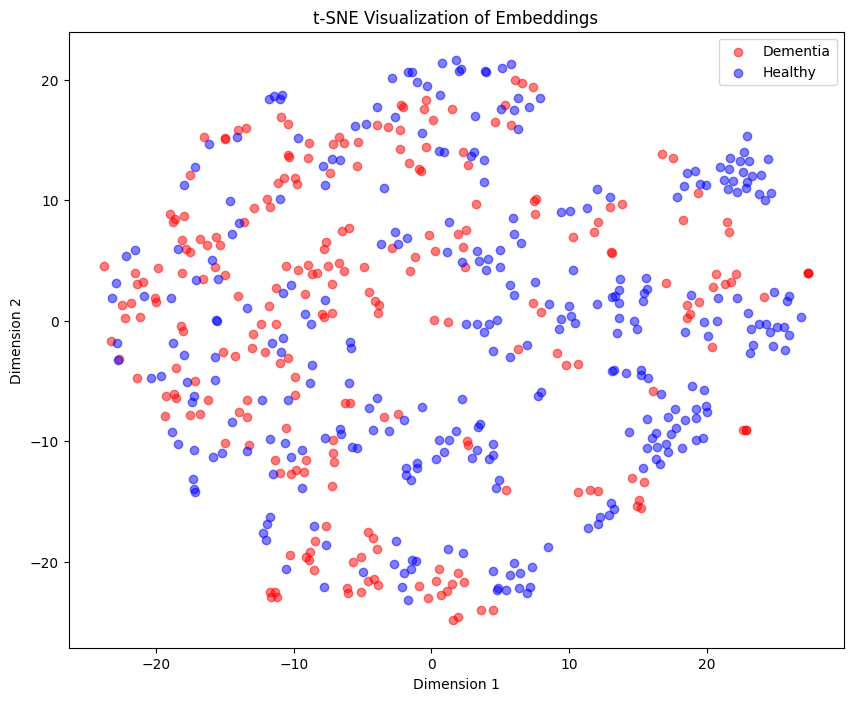

In [ ]:
# Use the base network to extract embeddings
embeddings = base_network.predict(images)

# Visualize using t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[labels == 0, 0], embeddings_2d[labels == 0, 1],
            label='Dementia', alpha=0.5, c='red')
plt.scatter(embeddings_2d[labels == 1, 0], embeddings_2d[labels == 1, 1],
            label='Healthy', alpha=0.5, c='blue')
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
# Split embeddings into training and validation sets
embeddings_train, embeddings_val, labels_train, labels_val = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42)

# Train a logistic regression classifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000)
classifier.fit(embeddings_train, labels_train)

# Predict on validation set
labels_pred = classifier.predict(embeddings_val)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(labels_val, labels_pred))

# Confusion matrix
conf_matrix = confusion_matrix(labels_val, labels_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        53
           1       0.68      0.81      0.74        58

    accuracy                           0.70       111
   macro avg       0.71      0.70      0.70       111
weighted avg       0.71      0.70      0.70       111

Confusion Matrix:
[[31 22]
 [11 47]]
